# Using Alphalens
In this example we will demonstrate how to create a simple pipeline that uses a factor and then analyze it using alphalens. 

#### Loading the data bundle

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
from datetime import timedelta

os.environ['ZIPLINE_ROOT'] = os.path.join(os.getcwd(), '.zipline')
os.listdir(os.environ['ZIPLINE_ROOT'])

os.environ['ZIPLINE_TRADER_CONFIG'] = os.path.join(os.getcwd(), "./zipline-trader.yaml")

with open(os.environ['ZIPLINE_TRADER_CONFIG'], 'r') as f:
    data = f.read()
    print(data[:20])
import zipline
from zipline.data import bundles

from zipline.utils.calendars import get_calendar
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.factors import CustomFactor
from zipline.research.utils import get_pricing, create_data_portal, create_pipeline_engine

# Set the trading calendar
trading_calendar = get_calendar('NYSE')
bundle_name = 'alpaca_api'
start_date = pd.Timestamp('2015-12-31', tz='utc')
pipeline_start_date = start_date + timedelta(days=365*2+10)
end_date = pd.Timestamp('2020-12-28', tz='utc')
data_portal = create_data_portal(bundle_name, trading_calendar, start_date)

## Creating the Pipeline Engine

In [3]:
engine = create_pipeline_engine(bundle_name)

## Let's create our custom factor
This is a factor that runs a linear regression over one year of stock log returns and calculates a "slope" as our factor.

In [4]:
from zipline.pipeline.factors import CustomFactor, Returns
from zipline.pipeline.data import USEquityPricing
        
class YearlyReturns(CustomFactor):
    inputs = [USEquityPricing.close]
    window_length = 252
    def compute(self, today, assets, out, prices):
        start = self.window_length
        out[:] = (prices[-1] - prices[-start])/prices[-start]


## Our Pipeline

In [7]:
from zipline.pipeline.domain import US_EQUITIES
from zipline.pipeline.factors import AverageDollarVolume
from zipline.pipeline import Pipeline
from zipline.pipeline.classifiers.custom.sector import ZiplineTraderSector, SECTOR_LABELS

universe = USEquityPricing
universe = AverageDollarVolume(window_length = 5)

pipeline = Pipeline(
    columns = {
            'MyFactor' : YearlyReturns(),
#             'Returns': Returns(window_length=252),  # same as YearlyRetruns
            'Sector' : ZiplineTraderSector()
    }, domain=US_EQUITIES
)

## Run the Pipeline

In [8]:
# Run our pipeline for the given start and end dates
factors = engine.run_pipeline(pipeline, pipeline_start_date, end_date)

factors.head()

MyFactor  Sector
2018-01-09 00:00:00+00:00 Equity(0 [A])     0.455036       1
                          Equity(1 [AAL])   0.118720      11
                          Equity(2 [ABC])   0.133466       7
                          Equity(3 [ABMD])  0.774400       7
                          Equity(4 [ADP])   0.150161      10


### Data preparation

Alphalens input consists of two type of information: the factor values for the time period under analysis and the historical assets prices (or returns). <br>Alphalens doesn't need to know how the factor was computed, the historical factor values are enough. This is interesting because we can use the tool to evaluate factors for which we have the data but not the implementation details.

Alphalens requires that factor and price data follows a specific format and it provides an utility function, ``get_clean_factor_and_forward_returns``, that accepts factor data, price data and optionally a group information (for example the sector groups, useful to perform sector specific analysis) and returns the data suitably formatted for Alphalens.


In [9]:
asset_list = factors.index.levels[1].unique()

prices = get_pricing(
        data_portal,
        trading_calendar,
        asset_list,
        pipeline_start_date,
        end_date)
prices.head()

,Equity(0 [A]),Equity(1 [AAL]),Equity(2 [ABC]),Equity(3 [ABMD]),Equity(4 [ADP]),Equity(5 [AEE]),Equity(6 [AES]),Equity(7 [AJG]),Equity(8 [ALB]),Equity(9 [ALK]),...,Equity(495 [TWTR]),Equity(496 [UNM]),Equity(497 [UNP]),Equity(498 [UPS]),Equity(499 [VMC]),Equity(500 [VRSK]),Equity(501 [VZ]),Equity(502 [WBA]),Equity(503 [WEC]),Equity(504 [ZTS])
2018-01-10 00:00:00+00:00,70.80,53.78,97.20,208.21,117.66,56.49,10.775,63.575,132.96,72.07,...,24.240,57.520,139.71,129.77,132.39,96.32,51.69,74.06,63.68,73.90
2018-01-11 00:00:00+00:00,70.80,56.18,98.12,210.17,117.18,56.15,10.960,63.390,134.68,74.82,...,24.340,58.210,140.40,133.46,135.18,96.67,52.12,75.36,63.58,74.60
2018-01-12 00:00:00+00:00,71.72,58.22,98.99,215.19,118.39,55.50,11.030,63.875,133.46,73.52,...,25.415,58.600,141.17,134.08,133.97,97.48,51.87,76.03,63.63,75.40
2018-01-16 00:00:00+00:00,71.24,57.73,99.55,218.27,119.38,55.45,10.680,63.410,128.00,71.28,...,24.680,55.530,140.30,132.90,133.67,97.19,51.66,76.03,63.15,75.55
2018-01-17 00:00:00+00:00,72.05,57.91,101.29,224.23,122.05,55.79,10.730,64.040,126.96,70.83,...,24.550,56.355,140.46,134.01,134.58,98.01,51.73,75.78,63.56,76.76


In [10]:
import alphalens as al

In [11]:
factor_data = al.utils.get_clean_factor_and_forward_returns(
        factor=factors["MyFactor"],
        prices=prices,
        quantiles=5,
        periods=[1, 5, 10],
        groupby=factors["Sector"],
        binning_by_group=True,
        groupby_labels=SECTOR_LABELS,
    max_loss=0.8)

Dropped 1.5% entries from factor data: 1.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 80.0%, not exceeded: OK!


In [12]:
factor_data.head(10)

1D        5D       10D  \
date                      asset                                            
2018-01-10 00:00:00+00:00 Equity(0 [A])     0.000000  0.019492  0.043079   
                          Equity(1 [AAL])   0.044626  0.080141 -0.017851   
                          Equity(2 [ABC])   0.009465  0.037757  0.073765   
                          Equity(3 [ABMD])  0.009414  0.084914  0.135200   
                          Equity(4 [ADP])  -0.004080  0.027707  0.025497   
                          Equity(5 [AEE])  -0.006019 -0.019295  0.004780   
                          Equity(6 [AES])   0.017169  0.070070  0.067285   
                          Equity(7 [AJG])  -0.002910  0.007000  0.032796   
                          Equity(8 [ALB])   0.012936 -0.113147 -0.120751   
                          Equity(9 [ALK])   0.038157 -0.031636 -0.138754   

                                              factor             group  \
date                      asset                                          
2018-01-10 00:00:00+00:00 Equity(0 [A])     0.491687     Capital Goods   
                          Equity(1 [AAL])   0.085696    Transportation   
                          Equity(2 [ABC])   0.149593       Health Care   
                          Equity(3 [ABMD])  0.868852       Health Care   
                          Equity(4 [ADP])   0.162133        Technology   
                          Equity(5 [AEE])   0.102944  Public Utilities   
                          Equity(6 [AES])  -0.050309  Basic Industries   
                          Equity(7 [AJG])   0.213659           Finance   
                          Equity(8 [ALB])   0.507343  Basic Industries   
                          Equity(9 [ALK])  -0.225000    Transportation   

                                            factor_quantile  
date                      asset                              
2018-01-10 00:00:00+00:00 Equity(0 [A])                   4  
                          Equity(1 [AAL])                 2  
                          Equity(2 [ABC])                 3  
                          Equity(3 [ABMD])                5  
                          Equity(4 [ADP])                 1  
                          Equity(5 [AEE])                 3  
                          Equity(6 [AES])                 1  
                          Equity(7 [AJG])                 3  
                          Equity(8 [ALB])                 5  
                          Equity(9 [ALK])                 1


### Running Alphalens

Once the factor data is ready, running Alphalens analysis is pretty simple and it consists of one function call that generates the factor report (statistical information and plots). Please remember that it is possible to use the help python built-in function to view the details of a function.


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.882437,0.336851,-0.221892,0.173761,77857,20.919291
2,-0.788964,0.440738,-0.049322,0.143953,74322,19.969477
3,-0.671378,0.560727,0.058053,0.144160,70527,18.949804
4,-0.570969,0.765367,0.176418,0.153070,74354,19.978075
5,-0.463738,9.102661,0.436519,0.325251,75118,20.183353


Returns Analysis


,1D,5D,10D
Ann. alpha,0.012,0.007,0.008
beta,-0.236,-0.309,-0.262
Mean Period Wise Return Top Quantile (bps),-0.345,-0.764,-0.528
Mean Period Wise Return Bottom Quantile (bps),3.034,2.960,2.288
Mean Period Wise Spread (bps),-3.380,-3.663,-2.783


<Figure size 432x288 with 0 Axes>

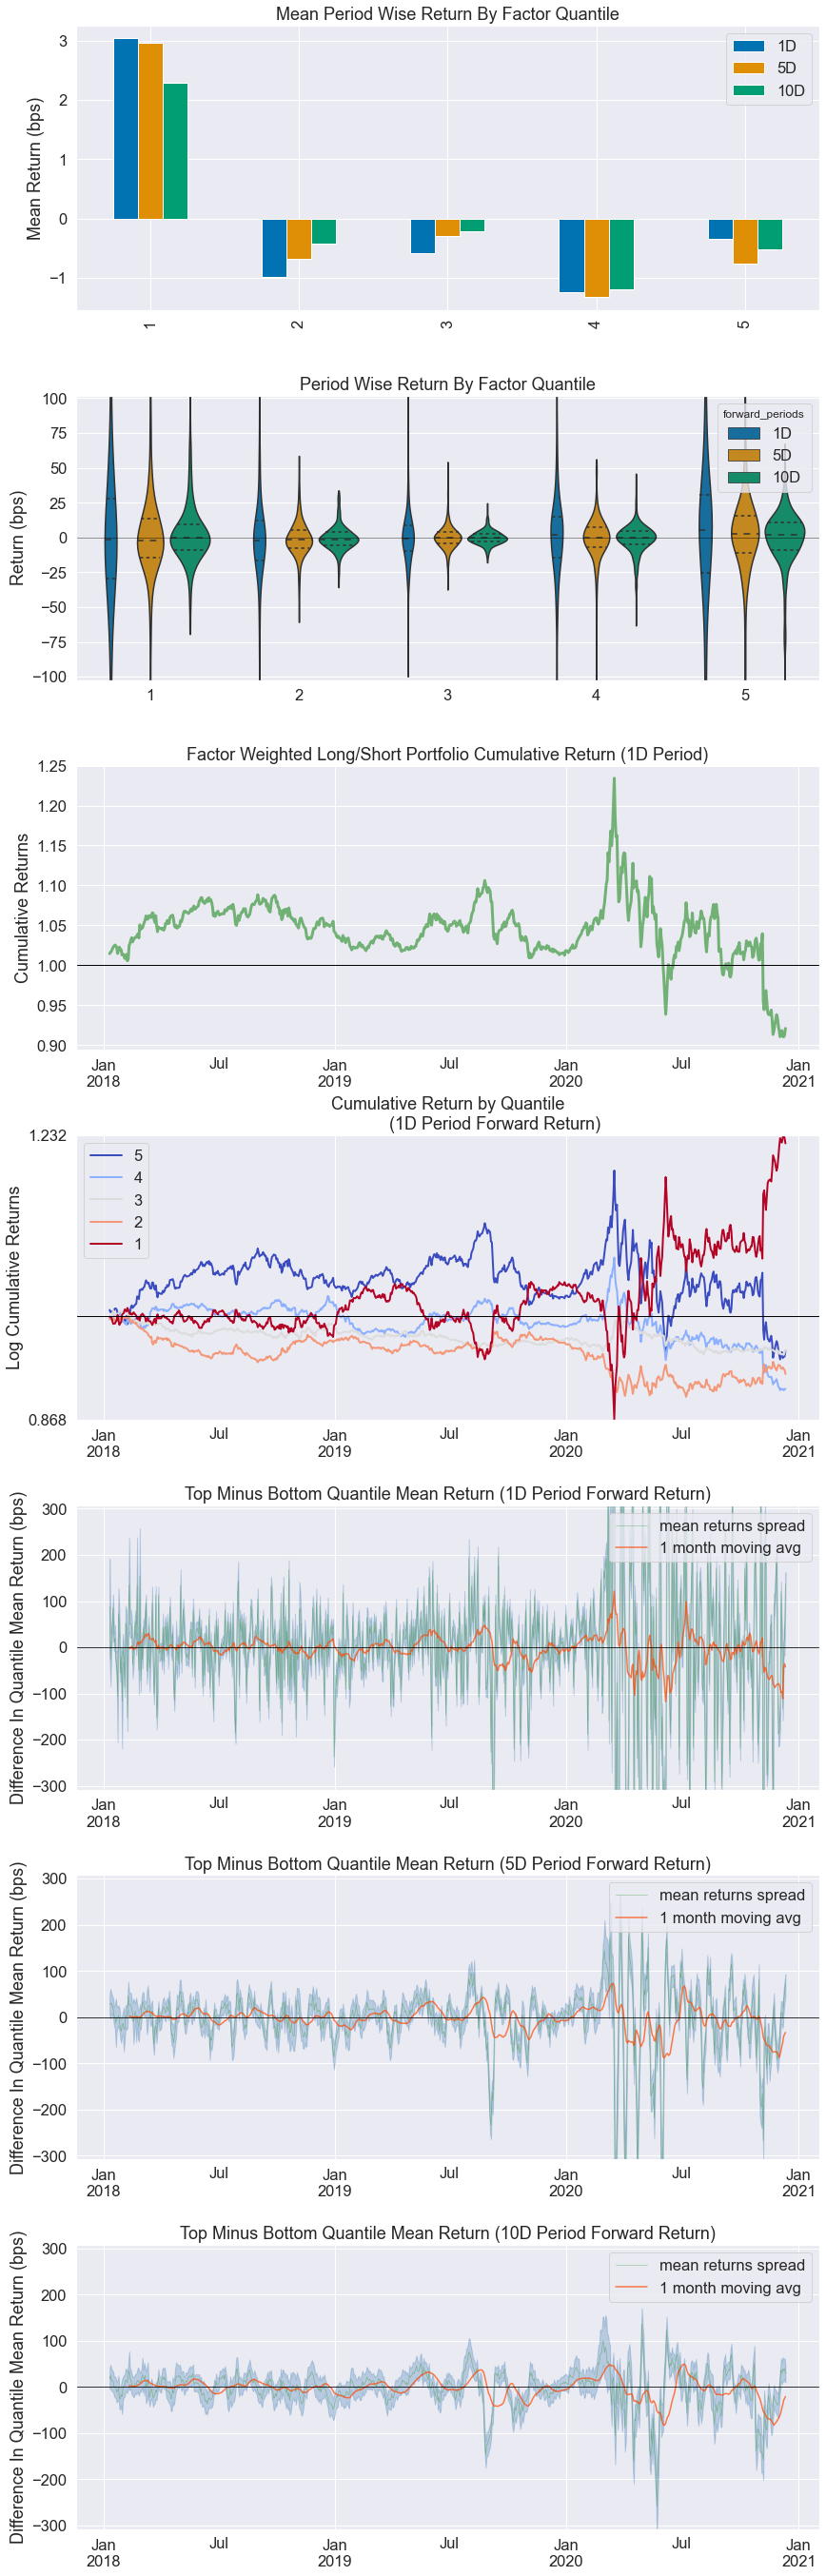

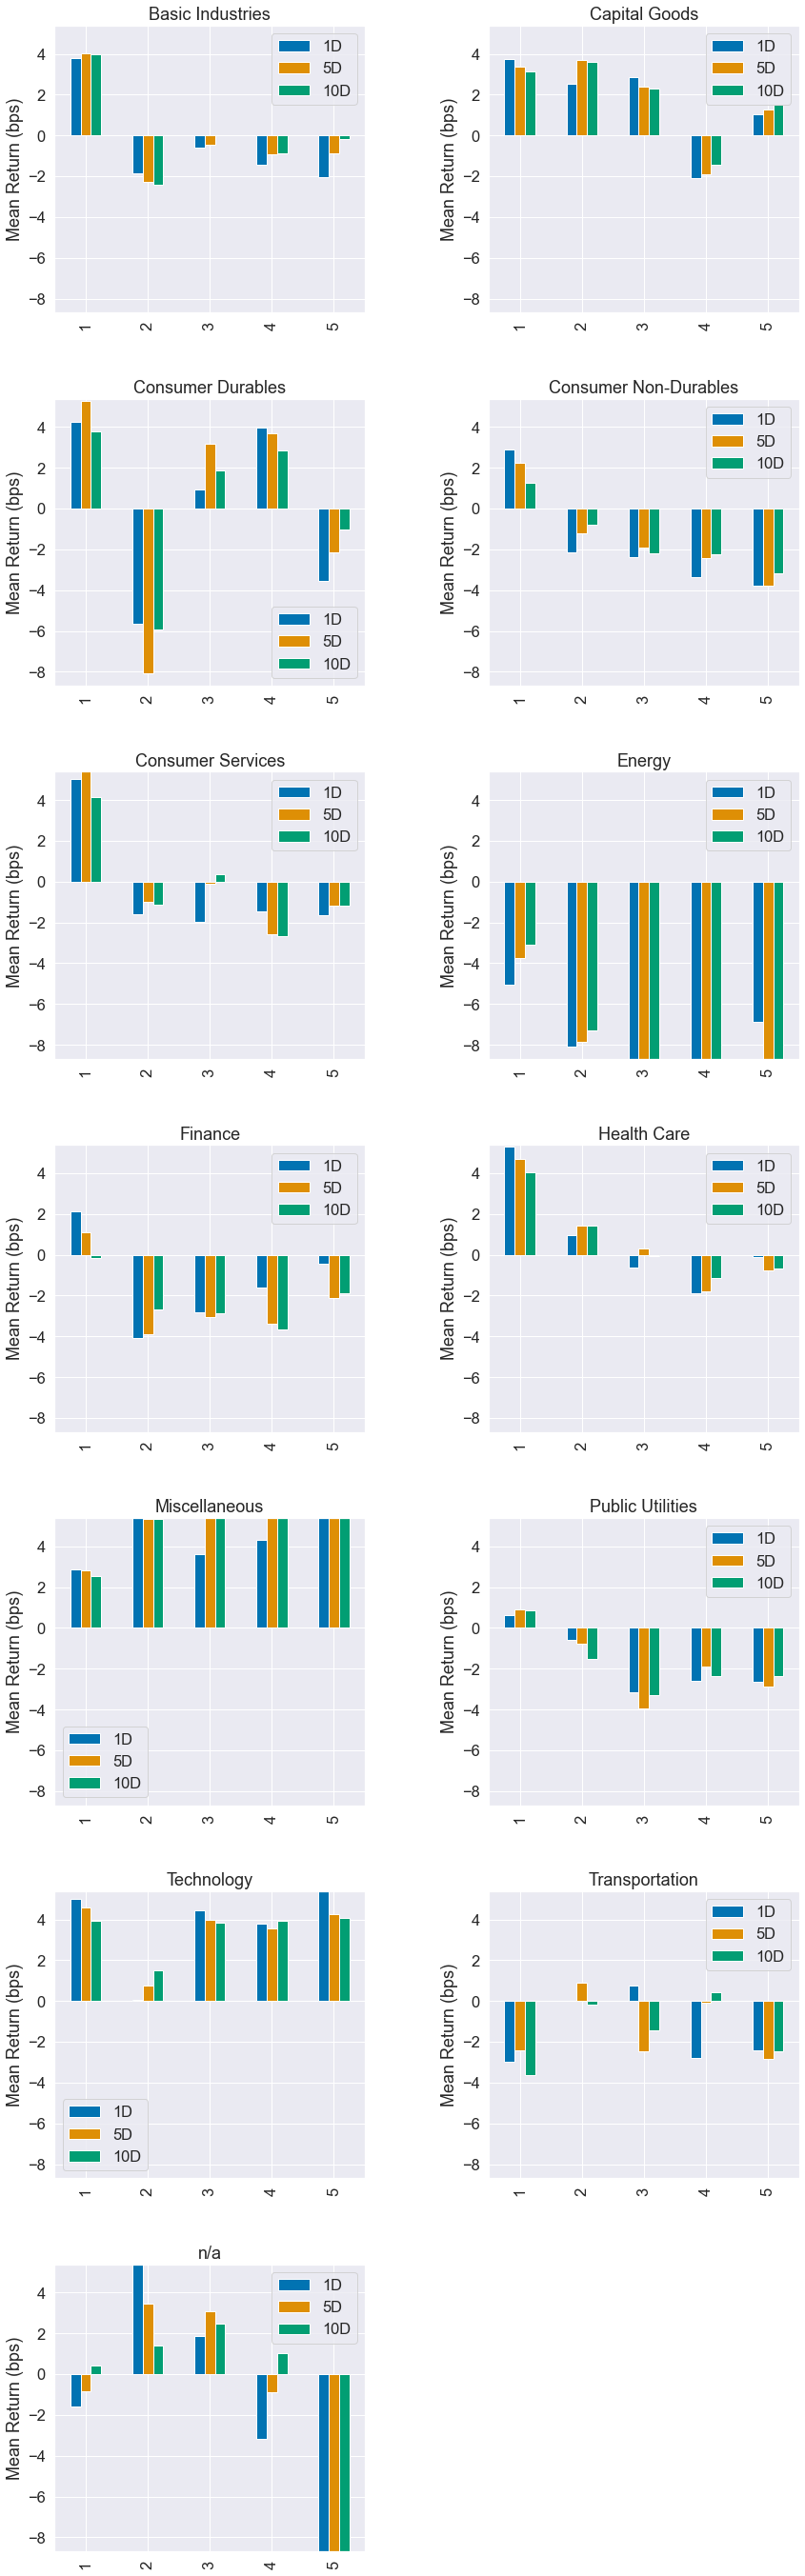

Information Analysis


,1D,5D,10D
IC Mean,0.017,0.017,0.010
IC Std.,0.274,0.279,0.272
Risk-Adjusted IC,0.061,0.060,0.036
t-stat(IC),1.648,1.640,0.970
p-value(IC),0.100,0.101,0.332
IC Skew,-0.228,-0.323,-0.357
IC Kurtosis,-0.256,-0.193,-0.076


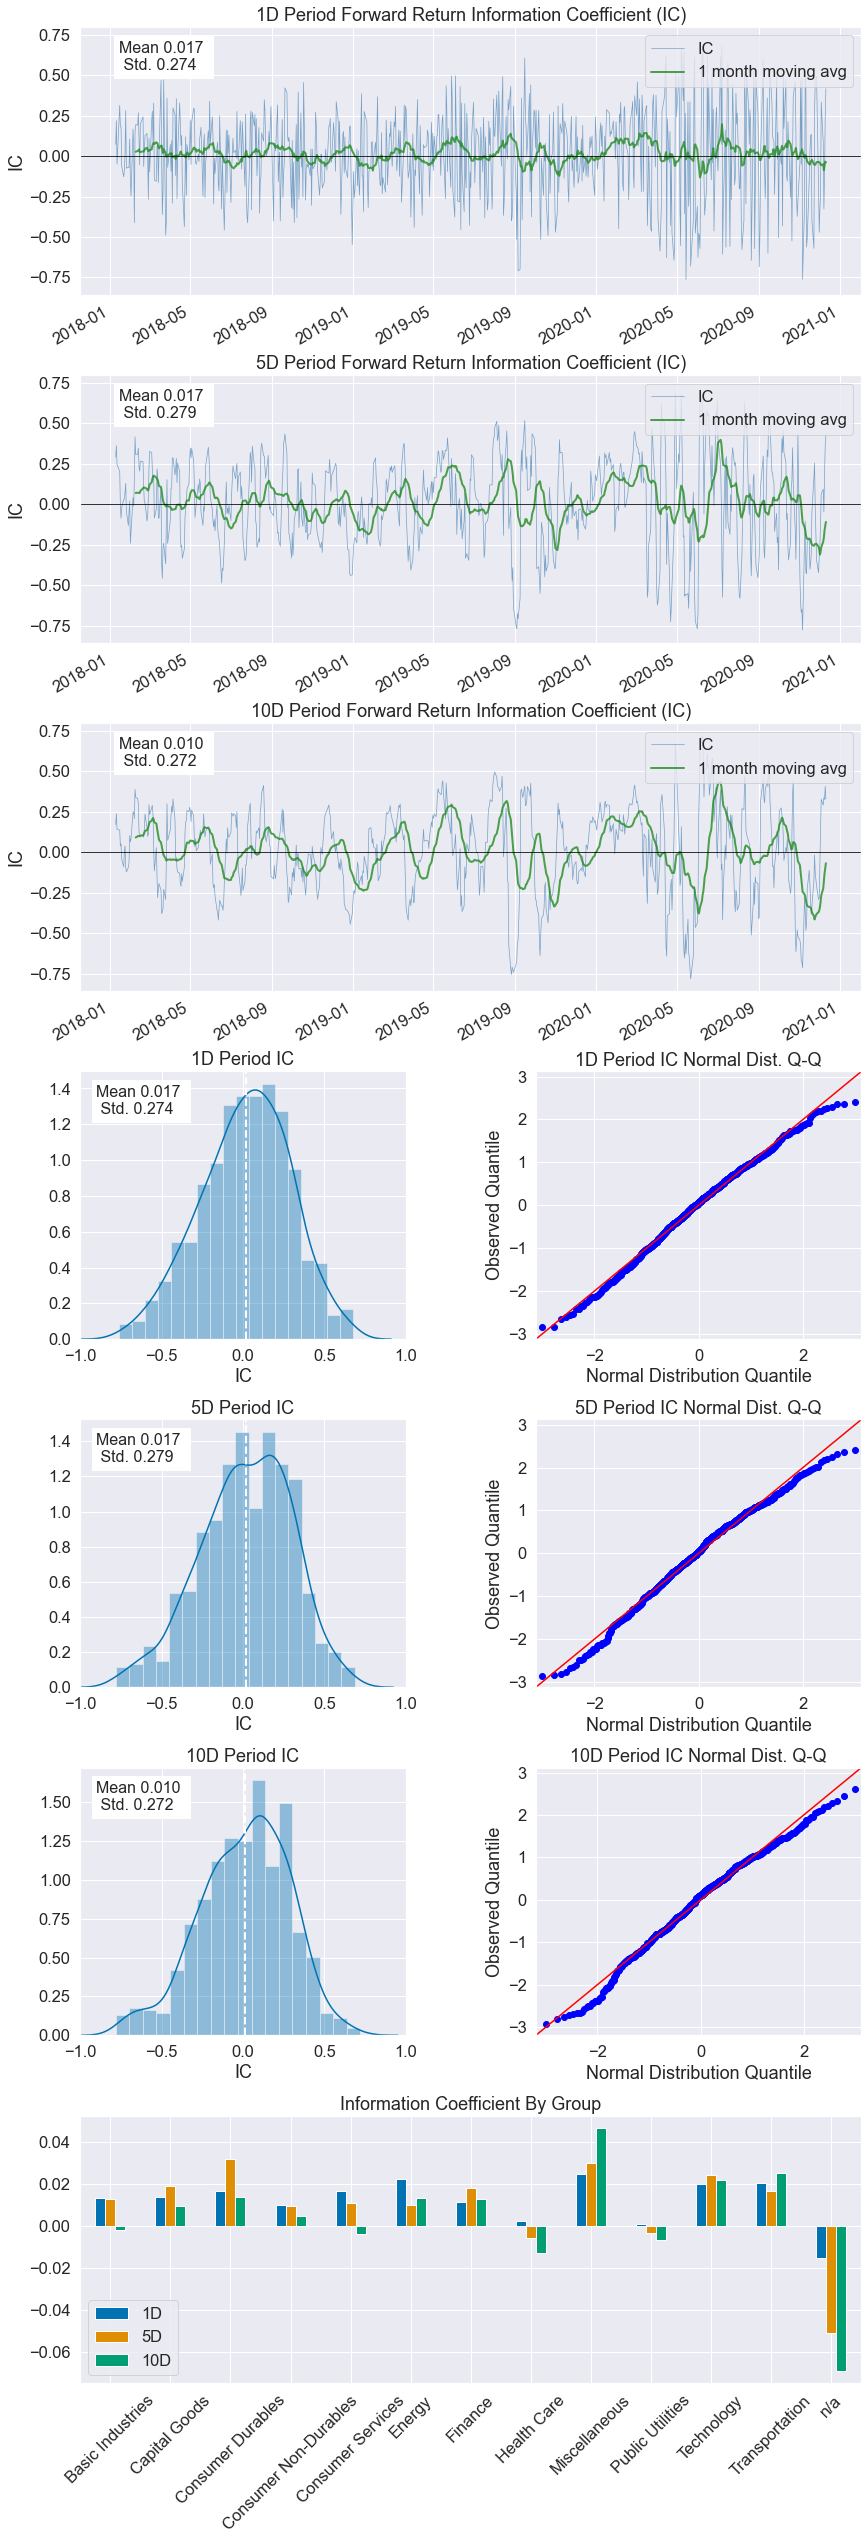

Turnover Analysis


,1D,5D,10D
Quantile 1 Mean Turnover,0.054,0.113,0.155
Quantile 2 Mean Turnover,0.132,0.267,0.354
Quantile 3 Mean Turnover,0.159,0.312,0.408
Quantile 4 Mean Turnover,0.131,0.265,0.353
Quantile 5 Mean Turnover,0.056,0.117,0.162


,1D,5D,10D
Mean Factor Rank Autocorrelation,0.994,0.975,0.954


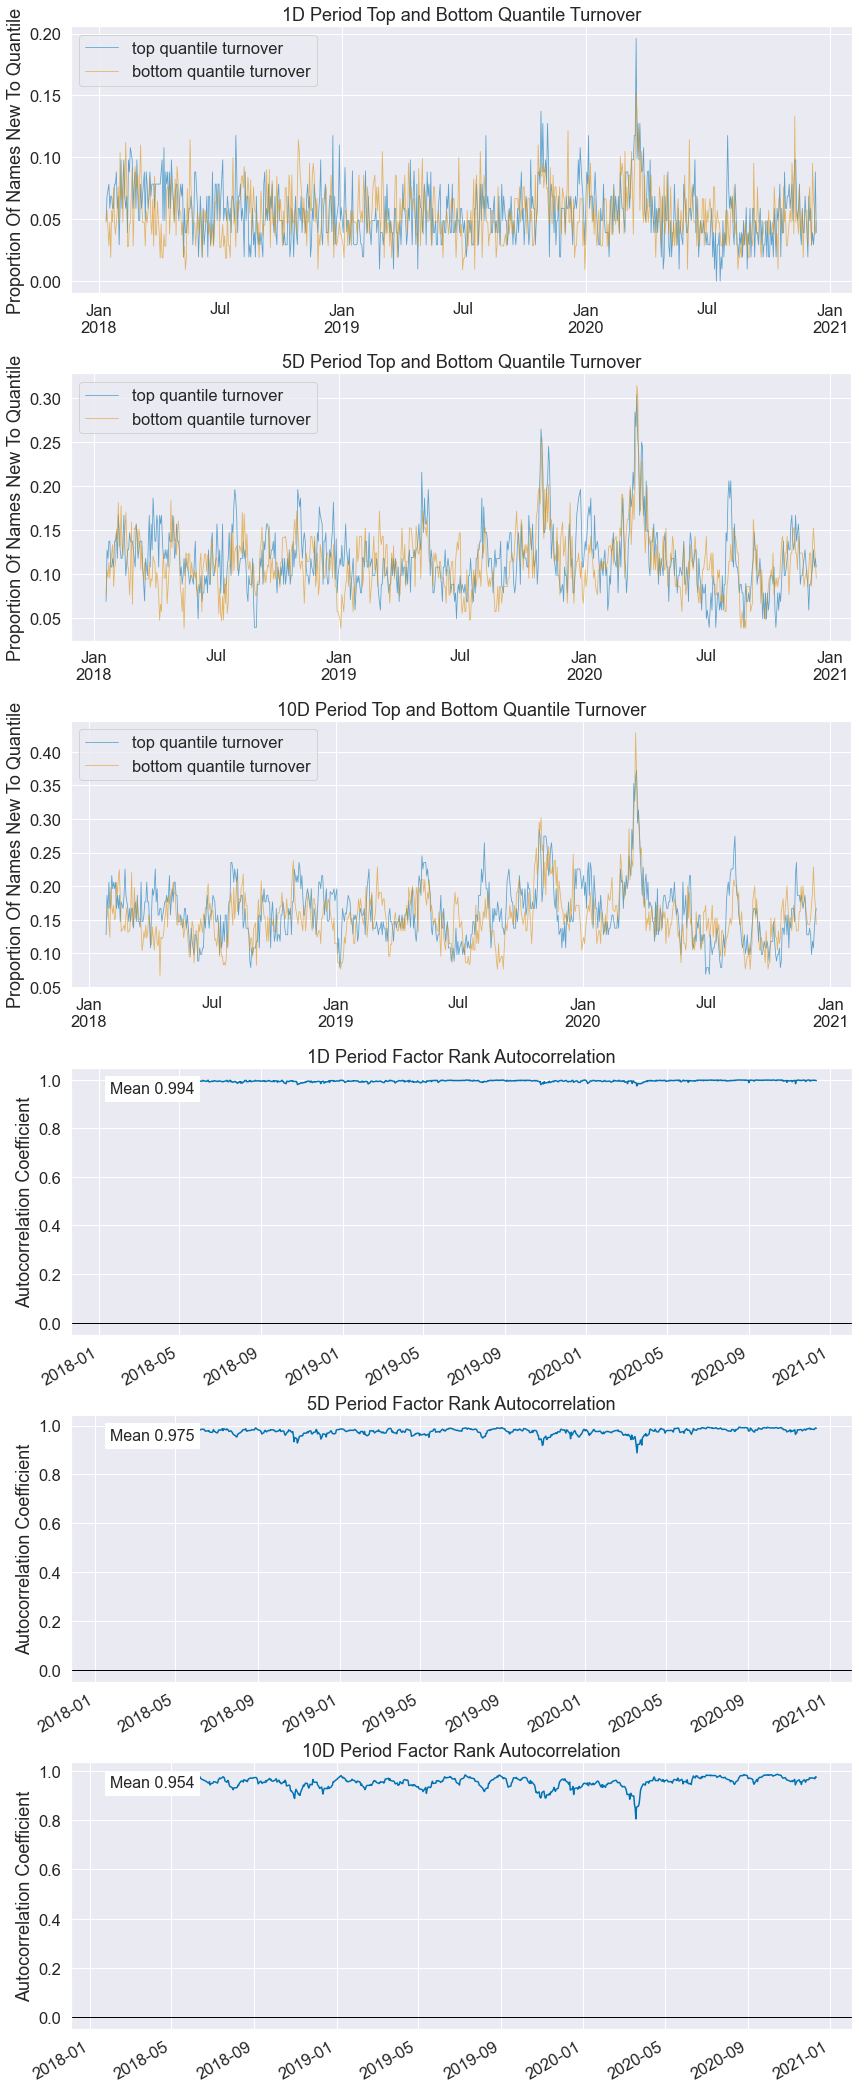

In [13]:
al.tears.create_full_tear_sheet(factor_data, long_short=True, group_neutral=False, by_group=True)

### These reports are also available

```py
al.tears.create_returns_tear_sheet(factor_data,
                                   long_short=True, 
                                   group_neutral=False, 
                                   by_group=False)

al.tears.create_information_tear_sheet(factor_data, 
                                       group_neutral=False,
                                       by_group=False)

al.tears.create_turnover_tear_sheet(factor_data)

al.tears.create_event_returns_tear_sheet(factor_data, prices,
                                         avgretplot=(5, 15),
                                         long_short=True,
                                         group_neutral=False,
                                         std_bar=True,
                                         by_group=False)
```

## Working with Pyfolio
We could use pyfolio to analyze the returns as if it was generated by a backtest, like so

In [14]:
pf_returns, pf_positions, pf_benchmark = \
    al.performance.create_pyfolio_input(factor_data,
                                        period='1D',
                                        capital=100000,
                                        long_short=True,
                                        group_neutral=False,
                                        equal_weight=True,
                                        quantiles=[1,5],
                                        groups=None,
                                        benchmark_period='1D')



Start date,2018-01-10
End date,2020-12-11
Total months,50
,Backtest
Annual return,-3.584%
Cumulative returns,-14.318%
Annual volatility,10.102%
Sharpe ratio,-0.31
Calmar ratio,-0.14
Stability,0.36
Max drawdown,-26.261%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,26.26,2020-03-17,2020-12-09,NaT,NaN
1,9.46,2019-08-26,2019-11-04,2020-03-11,143
2,5.86,2018-09-03,2019-04-17,2019-08-08,244
3,2.92,2018-06-04,2018-07-30,2018-08-31,65
4,1.90,2018-01-18,2018-02-07,2018-02-22,26


Stress Events,mean,min,max
New Normal,-0.01%,-7.48%,3.07%


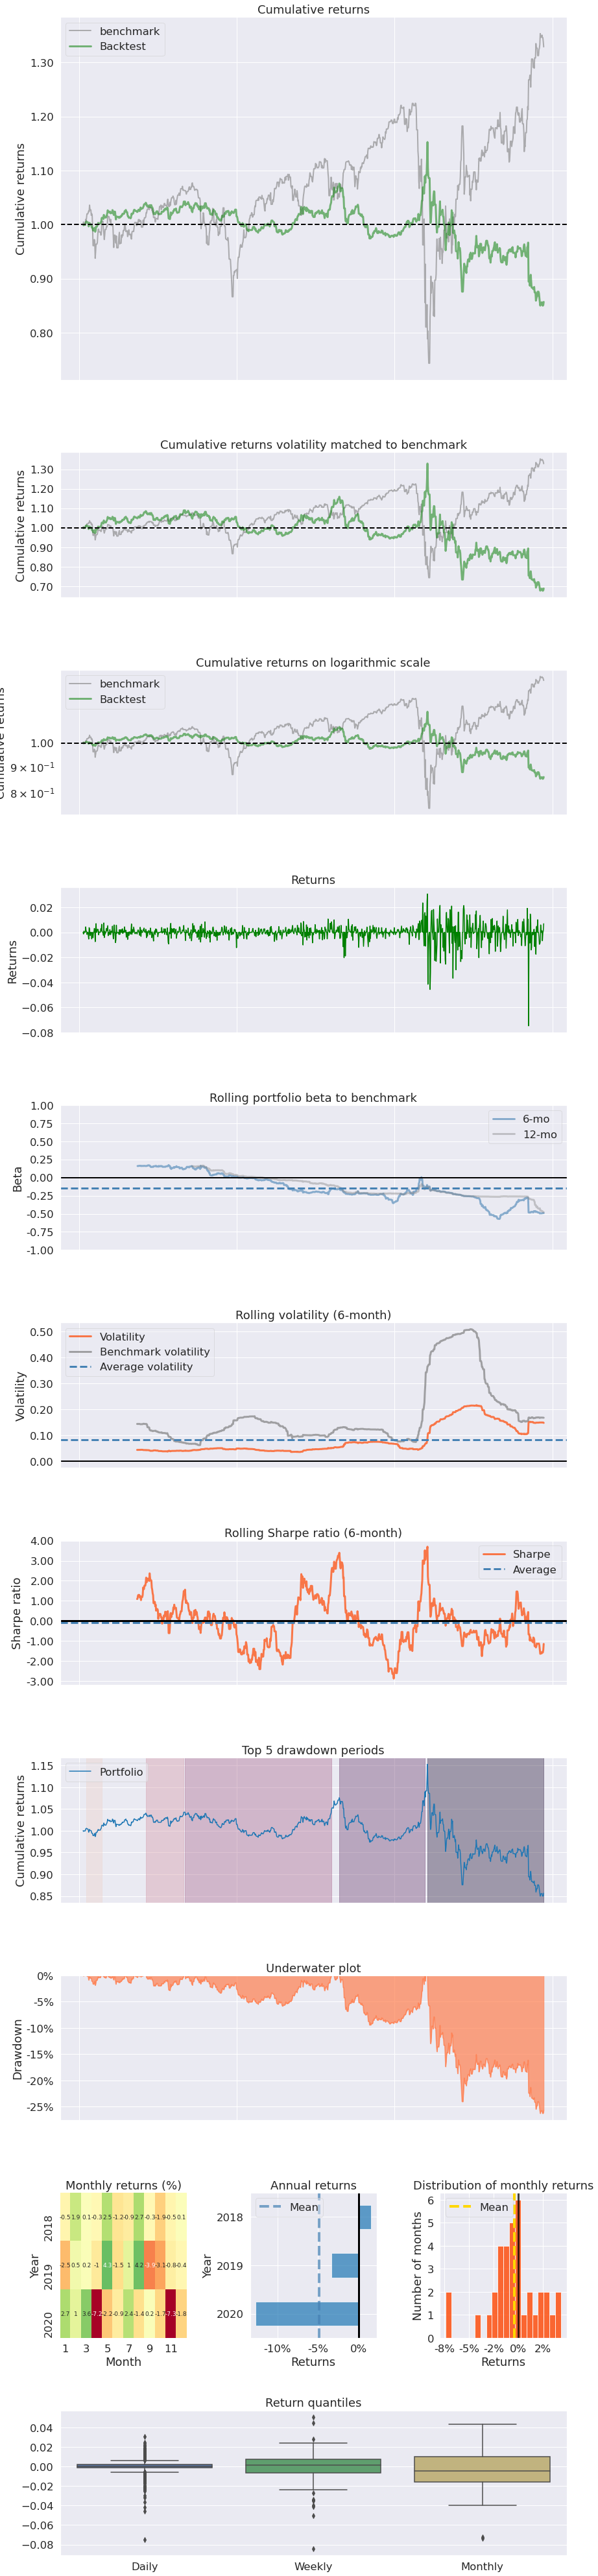

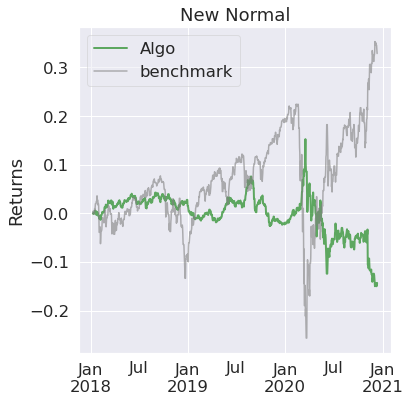

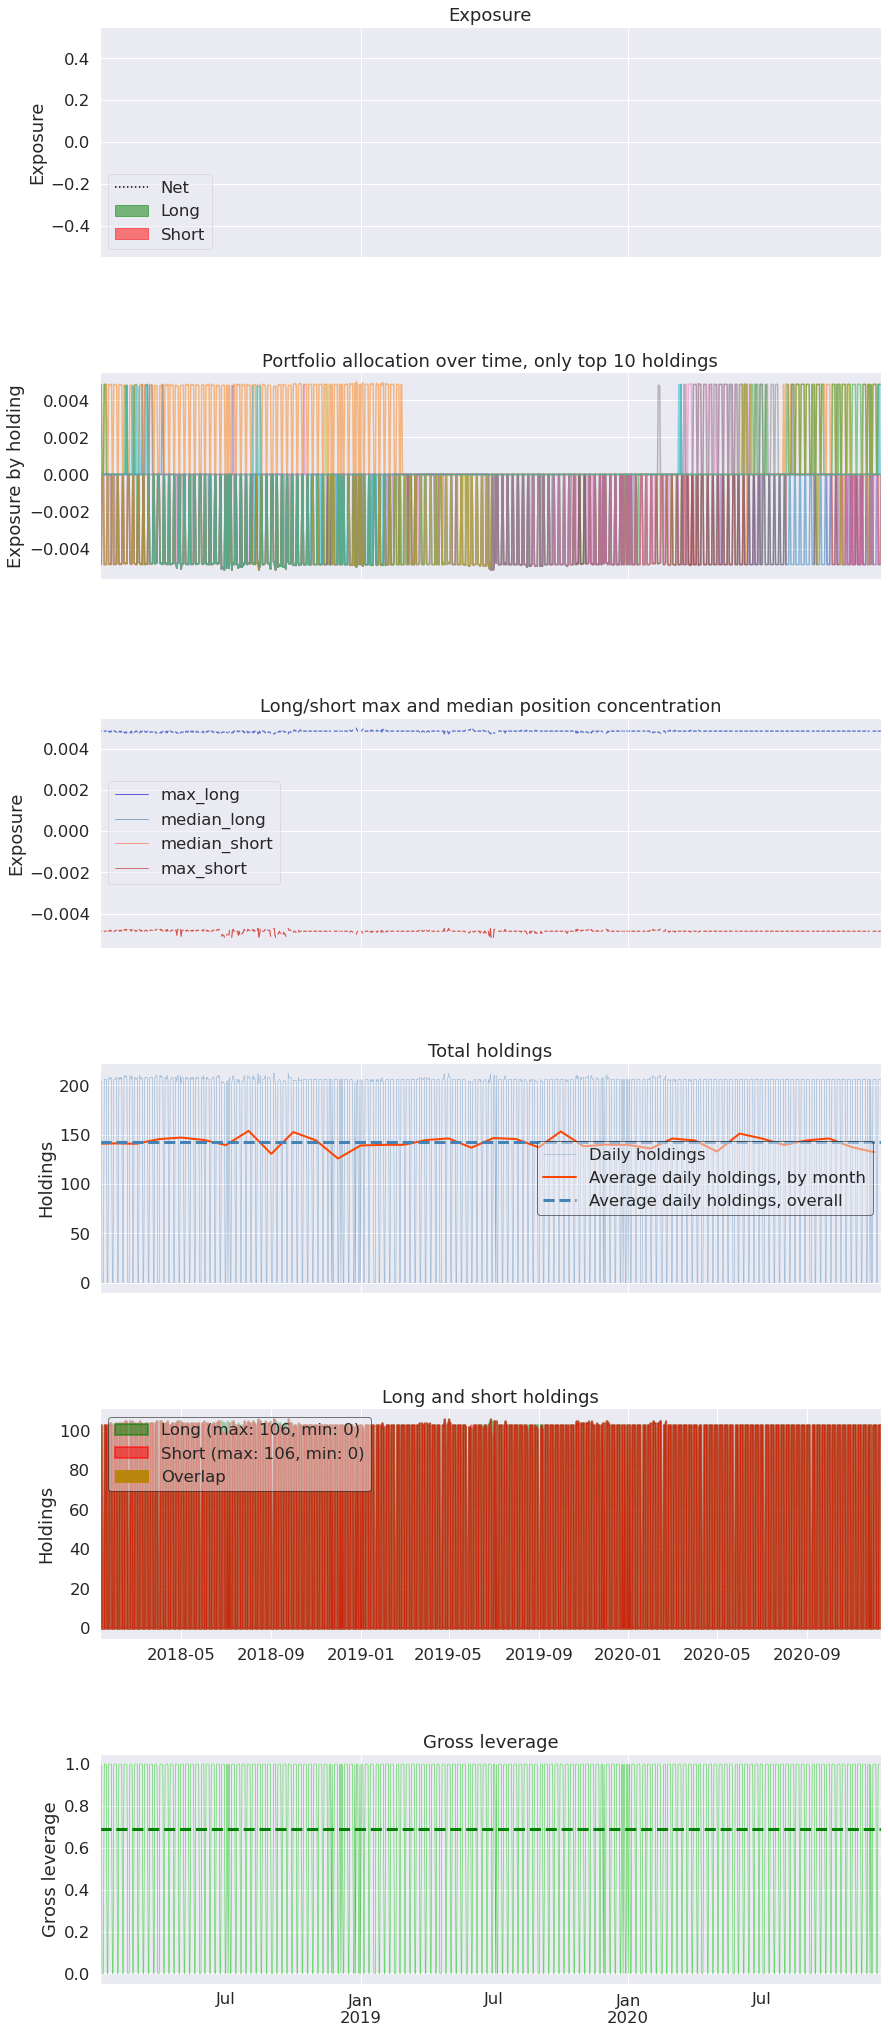

In [15]:
import pyfolio as pf
pf.tears.create_full_tear_sheet(pf_returns,
                                positions=pf_positions,
                                benchmark_rets=pf_benchmark,
                                hide_positions=True)